In [1]:
import copy
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset, DataLoader

import loralib

import bert_multi_lora
from custom_model import CustomBert, LoRABert

C:\Users\balanton\anaconda3\envs\semester_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext autoreload
# %autoreload 2

# Masking

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
# initialising the model
# bert = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
# bert = BertPreTrainedModel_masking.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

bert = bert_multi_lora.BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

In [5]:
def get_size_of_model(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    return (param_size + buffer_size) / 1024**2

def get_sizes(max_adapters=5):
    sizes = []
    sizes_full = []
    
    sizes.append({"model": "bert", "size": get_size_of_model(bert)})
    sizes_full.append({"model": "bert", "size": get_size_of_model(bert)})
    
    for i in range(1, max_adapters + 1):
        model_custom = CustomBert(copy.deepcopy(bert), num_adapters=i)
        models_LoRA = [LoRABert(copy.deepcopy(bert)) for _ in range(i)]
        
        sizes.append({"model": f"bert_{i}", "size": get_size_of_model(model_custom)})
        sizes_full.append({"model": f"bert_{i}", "size": sum([get_size_of_model(model) for model in models_LoRA])})
        
    return pd.DataFrame(sizes), pd.DataFrame(sizes_full)

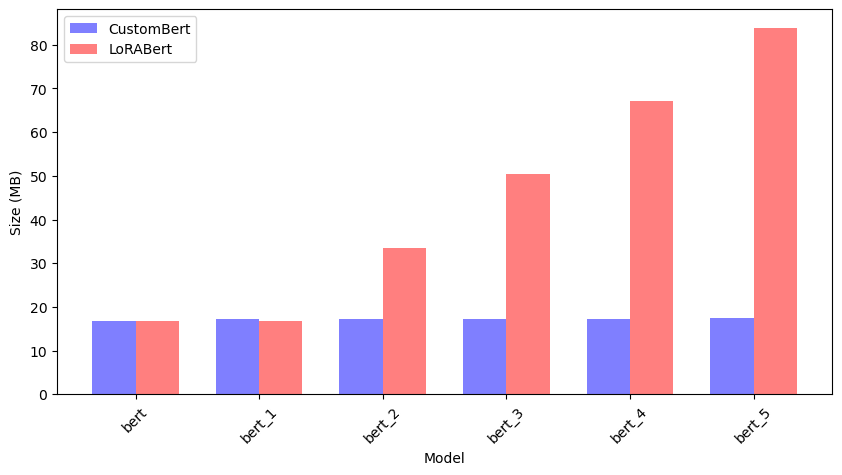

In [6]:
df_custom, df_LoRA = get_sizes(5)

fig, ax = plt.subplots(figsize=(10, 5))

index = np.arange(len(df_custom))
bar_width = 0.35

opacity = 0.5

ax.bar(index, df_custom["size"], bar_width, alpha=opacity, color='b', label='CustomBert')
ax.bar(index + bar_width, df_LoRA["size"], bar_width, alpha=opacity, color='r', label='LoRABert')

ax.legend()
ax.set_ylabel("Size (MB)")
ax.set_xlabel("Model")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_custom["model"], rotation=45)
plt.show()

In [7]:
# Define LoRA parameters
num_adapters = 2
rank = 8
alpha = 32

# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters, rank=rank, alpha=alpha).to(device)

In [8]:
class IMDBClassificationDataset(Dataset):
    def __init__(self, datasets, lora_cnt=2, id=None):
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        if self.id is not None:
            return len(self.datasets[0])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None:
            masking[self.id] = 1
            d = self.datasets[0][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_sst2(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

def tokenize_amazon(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=128)

def get_tokenized_datasets(paths, functions, split="train", batched=True, num_samples=1000):
    datasets = [load_dataset(path) for path in paths]
    tokenized_datasets = [dataset.map(function, batched=batched)[split].shuffle(seed=42).select(range(num_samples)) for dataset, function in zip(datasets, functions)]
    return tokenized_datasets

def get_dataloaders(tokenized_datasets, lora_cnt, split="train", batch_size=8):
    if split=="train":
        dataset = IMDBClassificationDataset(tokenized_datasets, lora_cnt=lora_cnt)
        return [DataLoader(dataset, shuffle=True, batch_size=batch_size)]
    elif split=="test":
        datasets = [IMDBClassificationDataset([tokenized_datasets[i]], lora_cnt=lora_cnt, id=i) for i in range(lora_cnt)]
        return [DataLoader(dataset, shuffle=False, batch_size=batch_size) for dataset in datasets]
    else:
        raise ValueError("Invalid split")

In [12]:
tokenized_test = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

Map: 100%|██████████| 3600000/3600000 [04:24<00:00, 13618.05 examples/s]


In [13]:
# Evaluate both adapters on respective datasets
model.eval()
criterion = torch.nn.BCELoss()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.7168739409446716
Adapter 1 loss: 0.7210031270980835


In [14]:
tokenized_datasets = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="train")

In [15]:
# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

# Mark only LoRA parameters as trainable
loralib.utils.mark_only_lora_as_trainable(model)

# Training loop
model.train()
criterion = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
train_dataloaders = get_dataloaders(tokenized_datasets, num_adapters, split="test")

num_epochs = 10
num_training_steps = num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps * num_adapters
)

In [28]:
lora_params_dict = {}

for i in range(num_adapters):
    lora_params_dict[f"adapters.{i}"] = []

for name, param in model.named_parameters():
    param.requires_grad = False
    
    if "adapters" in name:
        lora_params_dict[str.join(".", name.split(".")[-3:-1])].append(param)

In [35]:
# adapter_params = lora_params_dict["adapters.1"]
# for param in adapter_params:
#     print(param.requires_grad)
#     
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [29]:
start = time.time()

for i, train_dataloader in enumerate(train_dataloaders):
    adapter_params = lora_params_dict[f"adapters.{i}"]
    
    for param in adapter_params:
        param.requires_grad = True
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        for batch in train_dataloader:
            ids, masks, labels, masking = batch
            labels = labels.type(torch.float)
            o = model(ids.to(device), masks.to(device), masking.to(device))
    
            loss = criterion(torch.squeeze(o), labels.to(device))
            loss.backward()
    
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
    for param in adapter_params:
        param.requires_grad = False
        
print(f"Training time: {time.time() - start}")

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

Training time: 28.654502153396606


In [30]:
tokenized_test = get_tokenized_datasets(["imdb", "jahjinx/IMDb_movie_reviews"], [tokenize_imdb, tokenize_imdb], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

In [31]:
# Evaluate both adapters on respective datasets
model.eval()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.7102987232208252
Adapter 1 loss: 0.717850365638733


In [37]:
# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

# Mark only LoRA parameters as trainable
loralib.utils.mark_only_lora_as_trainable(model)

# Training loop
model.train()
criterion = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
train_dataloader = get_dataloaders(tokenized_datasets, num_adapters, split="train")[0]

num_epochs = 10
num_training_steps = num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps * num_adapters
)

In [43]:
start = time.time()

for epoch in tqdm.tqdm(range(num_epochs)):
    for batch in train_dataloader:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))

        losses = []
        for i in range(num_adapters):
            o_adapter = o.view(-1, num_adapters).t()[i]
            labels_adapter = labels.view(-1, num_adapters).t()[i]
            loss = criterion(o_adapter, labels_adapter.to(device))
            losses.append(loss)
            
        for i in range(num_adapters):
            losses[i].backward(retain_graph=True)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
print(f"Training time: {time.time() - start}")

100%|██████████| 10/10 [00:38<00:00,  3.84s/it]

Training time: 38.35575199127197


In [58]:
# Evaluate both adapters on respective datasets
model.eval()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6983270411491393
Adapter 1 loss: 0.7010941162109375


In [13]:
bert_normal = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
loraBert = LoRABert(copy.deepcopy(bert_normal)).to(device)

# Mark only LoRA parameters as trainable
loralib.utils.mark_only_lora_as_trainable(loraBert)

# Training loop
loraBert.train()
criterion = torch.nn.BCELoss()

tokenized_test = get_tokenized_datasets(["imdb", "jahjinx/IMDb_movie_reviews"], [tokenize_imdb, tokenize_imdb], num_samples=1000, split="train")
test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

num_epochs = 100

In [14]:
start = time.time()

for i in range(num_adapters):
    optimizer = AdamW(loraBert.parameters(), lr=5e-5)
    for epoch in tqdm.tqdm(range(num_epochs)):
        for batch in test_loaders[i]:
            ids, masks, labels, _ = batch
            labels = labels.type(torch.float)
            o = loraBert(ids.to(device), masks.to(device))

            loss = criterion(torch.squeeze(o), labels.to(device))
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

print(f"Training time: {time.time() - start}")

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]

Training time: 191.54238629341125


In [15]:
# save the tokenizer and the model in `./test-model/` directory 
tokenizer.save_pretrained("./test-model/")
model.save_pretrained("./test-model/", push_to_hub=False)

In [ ]:
from transformers import pipeline

# as this is classification so you need to mention `text-classification` as task
classifier = pipeline('text-classification', model='tanmoyio/test-model')
classifier("This movie was superb")


# Masking
---
# Parallel

In [2]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# initialising the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
bert = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
# bert = BertPreTrainedModel_masking.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

# Define LoRA parameters
rank = 8
num_adapters = 2

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# initialising the tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_sst2(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Now lets create the torch Dataset class
class IMDBClassificationDataset(Dataset):
    def __init__(self, datasets, lora_cnt=2, id=None):
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        if self.id is not None:
            return len(self.datasets[self.id])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None:
            masking[self.id] = 1    
            d = self.datasets[self.id][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
import concurrent


class ParallelTrainer:
    def __init__(self, model, device, num_adapters=2):
        self.model = model
        self.device = device
        self.num_adapters = num_adapters             
    
    def train_model(self, train_dataloader, num_epochs=3):
        # model.train()
        criterion = torch.nn.BCELoss()
        optimizer = AdamW(model.parameters(), lr=5e-5)
        num_training_steps = num_epochs * len(train_dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        for epoch in tqdm.tqdm(range(num_epochs)):
            for batch in train_dataloader:
                ids, masks, labels, masking = batch
                labels = labels.type(torch.float32)
                o = model(ids.to(device), masks.to(device), masking.to(device))
                loss = criterion(torch.squeeze(o), labels.to(device))
                loss.backward()

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad() 
                
    def train(self, train_dataloaders, num_epochs=3):
        model.train()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.train_model, dataloader, num_epochs) for dataloader in train_dataloaders]
            concurrent.futures.wait(futures)

In [5]:
from custom_model import CustomBert

model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

loralib.utils.mark_only_lora_as_trainable(model)

# Initialize the parallel trainer
trainer = ParallelTrainer(model, device, num_adapters=num_adapters)

In [6]:
imdb_dataset = load_dataset("imdb")
sst2_dataset = load_dataset("stanfordnlp/sst2")

tokenized_imdb = imdb_dataset.map(tokenize_imdb, batched=True)
tokenized_sst2 = sst2_dataset.map(tokenize_sst2, batched=True)

tokenized_imdb = tokenized_imdb["train"].shuffle(seed=42).select(range(1000))
tokenized_sst2 = tokenized_sst2["train"].shuffle(seed=42).select(range(1000))

tokenized_datasets = [tokenized_imdb, tokenized_sst2]

dataset_imdb = IMDBClassificationDataset(tokenized_datasets, lora_cnt=num_adapters, id=0)
dataset_sst2 = IMDBClassificationDataset(tokenized_datasets, lora_cnt=num_adapters, id=1)
test_loaders = [DataLoader(dataset_imdb, shuffle=False, batch_size=8), DataLoader(dataset_sst2, shuffle=False, batch_size=8)]

In [ ]:
trainer.train(test_loaders, num_epochs=3)


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\transformers\models\bert\modeling_bert.py:442: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
